In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import folium
import time
from datetime import datetime as dt
from geopy.distance import geodesic
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans

In [3]:
plt.style.use('ggplot')
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10,6)})

In [4]:
pd.options.display.float_format = '{:20,.5f}'.format

In [53]:
data_2014_jan = dd.read_csv('./dataset/2014/yellow_tripdata_2014-01.csv')
data_2015_jan = dd.read_csv('./dataset/2015/yellow_tripdata_2015-01.csv')
data_2016_jan = dd.read_csv('./dataset/2016/yellow_tripdata_2016-01.csv')

In [5]:
# data_2015_jan.visualize()

## Data Cleaning

#### Remove the pickup outliers

We remove all the pickup locations that are not in the vicinity in the NewYork city.

In [6]:
outlier_locations = data_2015_jan[((data_2015_jan.pickup_longitude <= -74.15) | 
                                   (data_2015_jan.pickup_latitude <= 40.5774)| \
                                   (data_2015_jan.pickup_longitude >= -73.7004) | 
                                   (data_2015_jan.pickup_latitude >= 40.9176))]
sl = outlier_locations.loc[0:10000, ['pickup_latitude',
                                    'pickup_longitude']]
sl = sl[sl.pickup_latitude != 0.0]
map_osm = folium.Map(location=[40.734695, -73.990372], 
                     width='70%', height='70%',
                     tiles='Stamen Toner')
for _, loc in sl.iterrows():
    folium.Marker([loc['pickup_latitude'], 
                   loc['pickup_longitude']]).add_to(map_osm)
map_osm

In [30]:
data_2014_jan.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.70000,-73.99477,40.73683,1,N,-73.98223,40.73179,CRD,6.50000,0.50000,0.50000,1.40000,0.00000,8.90000
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.40000,-73.98239,40.77338,1,N,-73.96045,40.76400,CRD,8.50000,0.50000,0.50000,1.90000,0.00000,11.40000
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.30000,-73.98857,40.73941,1,N,-73.98663,40.76522,CRD,11.50000,0.50000,0.50000,1.50000,0.00000,14.00000
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.70000,-73.96021,40.77046,1,N,-73.97986,40.77705,CRD,7.50000,0.50000,0.50000,1.70000,0.00000,10.20000
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.90000,-73.99537,40.71725,1,N,-73.98437,40.72052,CRD,6.00000,0.50000,0.50000,1.75000,0.00000,8.75000


In [54]:
data_2014_jan = data_2014_jan.rename(columns={" pickup_longitude": "pickup_longitude", 
                                         " pickup_latitude": "pickup_latitude",
                                         " pickup_datetime": "tpep_pickup_datetime",
                                         " dropoff_datetime": "tpep_dropoff_datetime",
                                         " dropoff_latitude": "dropoff_latitude",
                                         " dropoff_longitude": "dropoff_longitude",
                                         "  passenger_count": "passenger_count",
                                         " trip_distance": "trip_distance",
                                         " total_amount": "total_amount",
                                         " passenger_count": "passenger_count"})

In [55]:
data_2014_jan = data_2014_jan[((data_2014_jan.pickup_longitude >= -74.15) & 
                              (data_2014_jan.pickup_latitude >= 40.5774) &
                              (data_2014_jan.pickup_longitude <= -73.7004) & 
                              (data_2014_jan.pickup_latitude <= 40.9176))]

data_2015_jan = data_2015_jan[((data_2015_jan.pickup_longitude >= -74.15) & 
                              (data_2015_jan.pickup_latitude >= 40.5774) &
                              (data_2015_jan.pickup_longitude <= -73.7004) & 
                              (data_2015_jan.pickup_latitude <= 40.9176))]

data_2016_jan = data_2016_jan[((data_2016_jan.pickup_longitude >= -74.15) & 
                              (data_2016_jan.pickup_latitude >= 40.5774) &
                              (data_2016_jan.pickup_longitude <= -73.7004) & 
                              (data_2016_jan.pickup_latitude <= 40.9176))]

#### Remove the duration outliers

In [50]:
## Code Courtesy: AAIC

#The timestamps are converted to unix so as to get duration(trip-time) & 
# speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" 
# we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(dt.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(df):
    duration = df[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup)) / float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count','trip_distance','pickup_longitude',
                    'pickup_latitude','dropoff_longitude',
                    'dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60 * (new_frame['trip_distance'] / new_frame['trip_times'])
    
    return new_frame

In [51]:
data_2014_jan.columns

Index(['vendor_id', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       ' passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', ' rate_code', ' store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', ' payment_type',
       ' fare_amount', ' surcharge', ' mta_tax', ' tip_amount',
       ' tolls_amount', 'total_amount'],
      dtype='object')

In [56]:
%%time
data_2014_jan_with_durations = return_with_trip_times(data_2014_jan)
data_2015_jan_with_durations = return_with_trip_times(data_2015_jan)
data_2016_jan_with_durations = return_with_trip_times(data_2016_jan)

CPU times: user 21min 52s, sys: 2min 6s, total: 23min 59s
Wall time: 20min 40s


In [58]:
data_2014_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,0.70000,-73.99477,40.73683,-73.98223,40.73179,8.90000,7.10000,"1,389,300,325.00000",5.91549
1,1,1.40000,-73.98239,40.77338,-73.96045,40.76400,11.40000,9.00000,"1,389,300,372.00000",9.33333
2,2,2.30000,-73.98857,40.73941,-73.98663,40.76522,14.00000,14.98333,"1,389,300,287.00000",9.21023
3,1,1.70000,-73.96021,40.77046,-73.97986,40.77705,10.20000,6.71667,"1,389,300,297.00000",15.18610
4,1,0.90000,-73.99537,40.71725,-73.98437,40.72052,8.75000,6.38333,"1,389,300,429.00000",8.45953


In [60]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838


In [67]:
data_2014_jan_with_durations['trip_times'].quantile(np.arange(0, 1.1, 0.1))

0.00000           -1,200.00000
0.10000                4.00000
0.20000                5.26667
0.30000                7.00000
0.40000                8.11667
0.50000               10.00000
0.60000               12.00000
0.70000               14.03333
0.80000               17.71667
0.90000               23.18333
1.00000           19,517.30000
Name: trip_times, dtype: float64

In [68]:
data_2014_jan_with_durations['trip_times'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               23.18333
0.91000               24.00000
0.92000               25.00000
0.93000               26.28333
0.94000               28.00000
0.95000               29.23333
0.96000               31.33333
0.97000               34.00000
0.98000               38.00000
0.99000               46.00000
1.00000           19,517.30000
Name: trip_times, dtype: float64

In [69]:
data_2014_jan_with_durations.trip_times.describe()

count       13,592,685.00000
mean                12.29391
std                 11.30059
min             -1,200.00000
25%                  6.00000
50%                 10.00000
75%                 16.00000
max             19,517.30000
Name: trip_times, dtype: float64

In [70]:
data_2014_jan_with_durations = data_2014_jan_with_durations[(data_2014_jan_with_durations.trip_times >= 1.0) &
                                                            (data_2014_jan_with_durations.trip_times <= 48.0)]

In [71]:
data_2014_jan_with_durations.shape

(13414762, 10)

In [72]:
data_2015_jan_with_durations = data_2015_jan_with_durations[(data_2015_jan_with_durations.trip_times >= 1.0) &
                                                            (data_2015_jan_with_durations.trip_times <= 48.0)]

In [73]:
data_2016_jan_with_durations['trip_times'].quantile(np.arange(0, 1.1, 0.1))

0.00000                0.00000
0.10000                3.96667
0.20000                5.58333
0.30000                7.11667
0.40000                8.70000
0.50000               10.48333
0.60000               12.56667
0.70000               15.21667
0.80000               18.95000
0.90000               25.53333
1.00000          119,912.70000
Name: trip_times, dtype: float64

In [74]:
data_2016_jan_with_durations['trip_times'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               25.53333
0.91000               26.56667
0.92000               27.75000
0.93000               29.13333
0.94000               30.75000
0.95000               32.73333
0.96000               35.25000
0.97000               38.70000
0.98000               43.93333
0.99000               53.91667
1.00000          119,912.70000
Name: trip_times, dtype: float64

In [75]:
data_2016_jan_with_durations = data_2016_jan_with_durations[(data_2016_jan_with_durations.trip_times >= 1.0) &
                                                            (data_2016_jan_with_durations.trip_times <= 54.0)]

#### Remove the Speed outliers

In [76]:
data_2014_jan_with_durations['Speed'].quantile(np.arange(0, 1.1, 0.1))

0.00000                0.00000
0.10000                6.28188
0.20000                7.80000
0.30000                9.00000
0.40000               10.15714
0.50000               11.32500
0.60000               12.63158
0.70000               14.25000
0.80000               16.52459
0.90000               20.89091
1.00000            2,488.96552
Name: Speed, dtype: float64

In [77]:
data_2014_jan_with_durations['Speed'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               20.89091
0.91000               21.60815
0.92000               22.50000
0.93000               23.44828
0.94000               24.60000
0.95000               25.92857
0.96000               27.55500
0.97000               29.54407
0.98000               32.22024
0.99000               36.25000
1.00000            2,488.96552
Name: Speed, dtype: float64

In [78]:
data_2014_jan_with_durations['Speed'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               36.25000
0.99100               36.81429
0.99200               37.41935
0.99300               38.09334
0.99400               38.83846
0.99500               39.67480
0.99600               40.68000
0.99700               41.90069
0.99800               43.45714
0.99900               45.92087
1.00000            2,488.96552
Name: Speed, dtype: float64

In [79]:
data_2014_jan_with_durations = data_2014_jan_with_durations[
    (data_2014_jan_with_durations.Speed > 0.0) &
    (data_2014_jan_with_durations.Speed <= 46.0)]
data_2015_jan_with_durations = data_2015_jan_with_durations[
    (data_2015_jan_with_durations.Speed > 0.0) &
    (data_2015_jan_with_durations.Speed <= 46.0)]

In [80]:
data_2016_jan_with_durations['Speed'].quantile(np.arange(0, 1.1, 0.1))

0.00000                0.00000
0.10000                6.00954
0.20000                7.38170
0.30000                8.48469
0.40000                9.52686
0.50000               10.61321
0.60000               11.84494
0.70000               13.38462
0.80000               15.61191
0.90000               20.00914
1.00000       41,917,233.80282
Name: Speed, dtype: float64

In [81]:
data_2016_jan_with_durations['Speed'].quantile(np.arange(0.9, 1.01, 0.01))

0.90000               20.00914
0.91000               20.76923
0.92000               21.62809
0.93000               22.60870
0.94000               23.74208
0.95000               25.06773
0.96000               26.66667
0.97000               28.67086
0.98000               31.31931
0.99000               35.33710
1.00000       41,917,233.80282
Name: Speed, dtype: float64

In [82]:
data_2016_jan_with_durations['Speed'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               35.33710
0.99100               35.89286
0.99200               36.49770
0.99300               37.17290
0.99400               37.91183
0.99500               38.74919
0.99600               39.75261
0.99700               40.99010
0.99800               42.58565
0.99900               45.07046
1.00000       41,917,233.80282
Name: Speed, dtype: float64

In [19]:
data_2015_jan_with_durations.shape

(12281114, 10)

In [83]:
data_2016_jan_with_durations = data_2016_jan_with_durations[
    (data_2016_jan_with_durations.Speed > 0.0) &
    (data_2016_jan_with_durations.Speed <= 46.0)]

#### Remove the total fare outliers

In [84]:
data_2014_jan_with_durations['total_amount'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               61.83000
0.99100               62.90000
0.99200               64.66000
0.99300               66.50000
0.99400               69.30000
0.99500               69.30000
0.99600               69.38000
0.99700               70.00000
0.99800               72.83000
0.99900               85.20000
1.00000              450.50000
Name: total_amount, dtype: float64

In [85]:
data_2015_jan_with_durations['total_amount'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               63.13000
0.99100               63.80000
0.99200               66.00000
0.99300               68.13000
0.99400               69.60000
0.99500               69.69000
0.99600               69.75000
0.99700               70.95000
0.99800               73.20000
0.99900               86.45000
1.00000        3,950,611.60000
Name: total_amount, dtype: float64

In [86]:
data_2016_jan_with_durations['total_amount'].quantile(np.arange(0.99, 1.001, 0.001))

0.99000               66.34000
0.99100               68.34000
0.99200               69.99000
0.99300               69.99000
0.99400               70.01000
0.99500               70.01000
0.99600               70.01000
0.99700               72.92000
0.99800               77.80000
0.99900               92.88000
1.00000          111,271.65000
Name: total_amount, dtype: float64

In [87]:
## Taking fare threshold to be 1000. Courtesy to AAIC
data_2014_jan_with_durations = data_2014_jan_with_durations[
    (data_2014_jan_with_durations.total_amount >= 0.0) &
    (data_2014_jan_with_durations.total_amount <= 1000.0)]
data_2015_jan_with_durations = data_2015_jan_with_durations[
    (data_2015_jan_with_durations.total_amount >= 0.0) &
    (data_2015_jan_with_durations.total_amount <= 1000.0)]
data_2016_jan_with_durations = data_2016_jan_with_durations[
    (data_2016_jan_with_durations.total_amount >= 0.0) &
    (data_2016_jan_with_durations.total_amount <= 1000.0)]

In [88]:
data_2014_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,0.70000,-73.99477,40.73683,-73.98223,40.73179,8.90000,7.10000,"1,389,300,325.00000",5.91549
1,1,1.40000,-73.98239,40.77338,-73.96045,40.76400,11.40000,9.00000,"1,389,300,372.00000",9.33333
2,2,2.30000,-73.98857,40.73941,-73.98663,40.76522,14.00000,14.98333,"1,389,300,287.00000",9.21023
3,1,1.70000,-73.96021,40.77046,-73.97986,40.77705,10.20000,6.71667,"1,389,300,297.00000",15.18610
4,1,0.90000,-73.99537,40.71725,-73.98437,40.72052,8.75000,6.38333,"1,389,300,429.00000",8.45953


In [89]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838


In [90]:
data_2016_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed
5,2,5.52000,-73.98012,40.74305,-73.91349,40.76314,20.30000,18.50000,"1,451,606,400.00000",17.90270
6,2,7.45000,-73.99406,40.71999,-73.96636,40.78987,27.30000,26.75000,"1,451,606,400.00000",16.71028
7,1,1.20000,-73.97942,40.74461,-73.99203,40.75394,10.30000,11.90000,"1,451,606,401.00000",6.05042
8,1,6.00000,-73.94715,40.79105,-73.92077,40.86558,19.30000,11.20000,"1,451,606,402.00000",32.14286
9,1,3.21000,-73.99834,40.72390,-73.99585,40.68840,12.80000,11.10000,"1,451,606,402.00000",17.35135


## Segment the NYC region into smaller regions

#### Getting the best number of smaller regions

In [101]:
pickup_cords_2014 = data_2014_jan_with_durations[['pickup_latitude', 'pickup_longitude']].values
pickup_cords_2015 = data_2015_jan_with_durations[['pickup_latitude', 'pickup_longitude']].values
pickup_cords_2016 = data_2016_jan_with_durations[['pickup_latitude', 'pickup_longitude']].values

In [92]:
def get_cluster_performance(cluster_centers, threshold):
    """
    It measures and report the cluster performance 
    by calculating the average number of clusters
    more than and less than the `threshold` inter-cluster
    distance and also reprots the minimum and maximum 
    distance betweent the clusters.
    
    :param cluster_centers: <np.ndarray> All the cluster centers
    :param threshold: <float> Distance in miles considered as threshold 
    """
    k = len(cluster_centers)
    nice_points = 0
    wrong_points = 0
    distances = []
    for i in range(0, k):
        for j in range(0, k):
            if i != j:
                distance = geodesic(cluster_centers[i], 
                                    cluster_centers[j]).miles
                if distance < threshold:
                    nice_points += 1
                else:
                    wrong_points += 1
                distances.append(distance)
    print('•' * 20, end='')
    print(' k={} '.format(k), end='')
    print('•' * 20)
    print('• Avg. number of clusters within {} miles: {}'.format(threshold, 
                                                               np.ceil(nice_points / k)))
    print('• Avg. number of clusters not within {} miles: {}'.format(threshold, 
                                                               np.ceil(wrong_points / k)))
    print('• Minimum distance between clusters: ', min(distances))
    print('• Maximum distance between clusters:', max(distances))
    print('•' * 45)

In [93]:
def get_clusters(data: np.ndarray, k: int) -> np.ndarray:
    """
    This fits the data using `k` clusters on the `data` and
    returns the k cluster centers.
    
    :param data: <np.ndarray> Data to cluster
    :param k: <int> Number of cluster centers
    """
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    assert(len(centers) == k)
    return centers

In [95]:
for k in range(10, 100, 10):
    centers = get_clusters(pickup_cords_2014, k)
    get_cluster_performance(centers, 2.0)

•••••••••••••••••••• k=10 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 2.0
• Avg. number of clusters not within 2.0 miles: 7.0
• Minimum distance between clusters:  0.879904205322304
• Maximum distance between clusters: 13.93445428461895
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=20 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 5.0
• Avg. number of clusters not within 2.0 miles: 15.0
• Minimum distance between clusters:  0.5279663693454189
• Maximum distance between clusters: 14.08059421096146
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=30 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 7.0
• Avg. number of clusters not within 2.0 miles: 23.0
• Minimum distance between clusters:  0.5110687339614595
• Maximum distance between clusters: 14.79611837687318
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=40 ••••••••••••••••••••
• Avg. number of clusters within 2.0 

In [96]:
for k in range(10, 100, 10):
    centers = get_clusters(pickup_cords_2015, k)
    get_cluster_performance(centers, 2.0)

•••••••••••••••••••• k=10 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 2.0
• Avg. number of clusters not within 2.0 miles: 8.0
• Minimum distance between clusters:  0.9157176298693095
• Maximum distance between clusters: 14.171969666790561
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=20 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 5.0
• Avg. number of clusters not within 2.0 miles: 15.0
• Minimum distance between clusters:  0.5181349359895029
• Maximum distance between clusters: 14.18705681181196
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=30 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 8.0
• Avg. number of clusters not within 2.0 miles: 22.0
• Minimum distance between clusters:  0.47148554182798474
• Maximum distance between clusters: 15.756136469491306
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=40 ••••••••••••••••••••
• Avg. number of clusters within 

In [102]:
for k in range(10, 100, 10):
    centers = get_clusters(pickup_cords_2016, k)
    get_cluster_performance(centers, 2.0)

•••••••••••••••••••• k=10 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 2.0
• Avg. number of clusters not within 2.0 miles: 8.0
• Minimum distance between clusters:  1.0725860892303982
• Maximum distance between clusters: 13.846459006328331
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=20 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 4.0
• Avg. number of clusters not within 2.0 miles: 16.0
• Minimum distance between clusters:  0.6914382154786726
• Maximum distance between clusters: 14.527342960752453
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=30 ••••••••••••••••••••
• Avg. number of clusters within 2.0 miles: 7.0
• Avg. number of clusters not within 2.0 miles: 23.0
• Minimum distance between clusters:  0.4791513688243008
• Maximum distance between clusters: 15.52715405564643
•••••••••••••••••••••••••••••••••••••••••••••
•••••••••••••••••••• k=40 ••••••••••••••••••••
• Avg. number of clusters within 2

For me k=50 feels a kind of a sweet spot for a large number of points within the 2 miles threshold value and having minimum cluster distance of 0.3 miles. I guess a driver won't feel weird to travel 0.3 miles for more pickups.

In [112]:
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=42)
kmeans.fit(pickup_cords_2014)
regions_2014 = kmeans.predict(pickup_cords_2014)

In [98]:
regions_2014

array([44, 21, 41, ..., 17, 12, 35], dtype=int32)

In [113]:
# kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=42)
# kmeans.fit(pickup_cords_2015)
regions_2015 = kmeans.predict(pickup_cords_2015)
regions_2015

array([ 5,  0, 14, ...,  9, 37, 24], dtype=int32)

In [114]:
# kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=42)
# kmeans.fit(pickup_cords_2016)
regions_2016 = kmeans.predict(pickup_cords_2016)
regions_2016

array([ 9, 27,  9, ..., 32, 11, 32], dtype=int32)

In [115]:
data_2014_jan_with_durations['region'] = regions_2014
data_2015_jan_with_durations['region'] = regions_2015
data_2016_jan_with_durations['region'] = regions_2016

In [116]:
data_2014_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,region
0,1,0.70000,-73.99477,40.73683,-73.98223,40.73179,8.90000,7.10000,"1,389,300,325.00000",5.91549,44
1,1,1.40000,-73.98239,40.77338,-73.96045,40.76400,11.40000,9.00000,"1,389,300,372.00000",9.33333,21
2,2,2.30000,-73.98857,40.73941,-73.98663,40.76522,14.00000,14.98333,"1,389,300,287.00000",9.21023,41
3,1,1.70000,-73.96021,40.77046,-73.97986,40.77705,10.20000,6.71667,"1,389,300,297.00000",15.18610,18
4,1,0.90000,-73.99537,40.71725,-73.98437,40.72052,8.75000,6.38333,"1,389,300,429.00000",8.45953,27


In [117]:
data_2015_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,region
0,1,1.59000,-73.99390,40.75011,-73.97478,40.75062,17.05000,18.05000,"1,421,348,739.00000",5.28532,5
1,1,3.30000,-74.00165,40.72424,-73.99442,40.75911,17.80000,19.83333,"1,420,922,018.00000",9.98319,0
2,1,1.80000,-73.96334,40.80279,-73.95182,40.82441,10.80000,10.05000,"1,420,922,018.00000",10.74627,14
3,1,0.50000,-74.00909,40.71382,-74.00433,40.71999,4.80000,1.86667,"1,420,922,019.00000",16.07143,47
4,1,3.00000,-73.97118,40.76243,-74.00418,40.74265,16.30000,19.31667,"1,420,922,019.00000",9.31838,1


In [118]:
data_2016_jan_with_durations.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,region
5,2,5.52000,-73.98012,40.74305,-73.91349,40.76314,20.30000,18.50000,"1,451,606,400.00000",17.90270,9
6,2,7.45000,-73.99406,40.71999,-73.96636,40.78987,27.30000,26.75000,"1,451,606,400.00000",16.71028,27
7,1,1.20000,-73.97942,40.74461,-73.99203,40.75394,10.30000,11.90000,"1,451,606,401.00000",6.05042,9
8,1,6.00000,-73.94715,40.79105,-73.92077,40.86558,19.30000,11.20000,"1,451,606,402.00000",32.14286,35
9,1,3.21000,-73.99834,40.72390,-73.99585,40.68840,12.80000,11.10000,"1,451,606,402.00000",17.35135,0


#### Plotting the cluster centers

In [157]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

#### Plotting the clusters

In [119]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.region.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

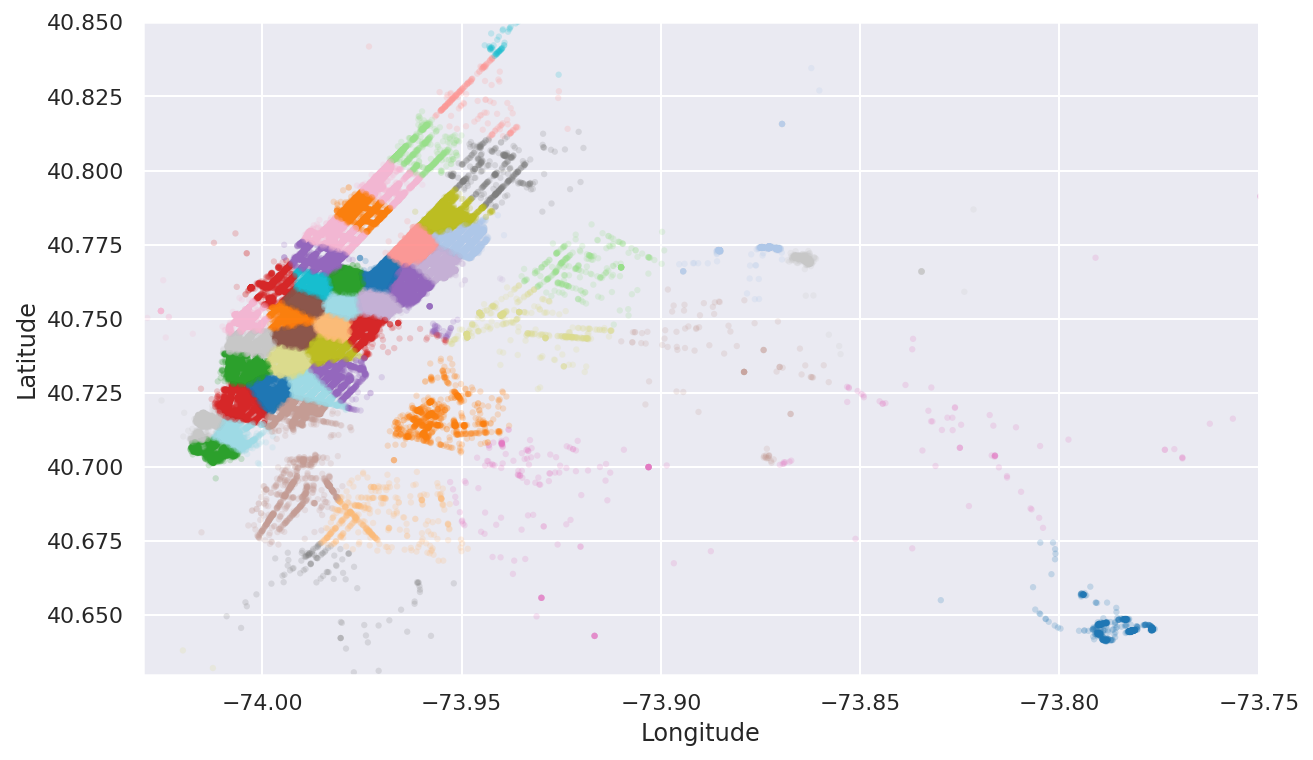

In [120]:
plot_clusters(data_2014_jan_with_durations)

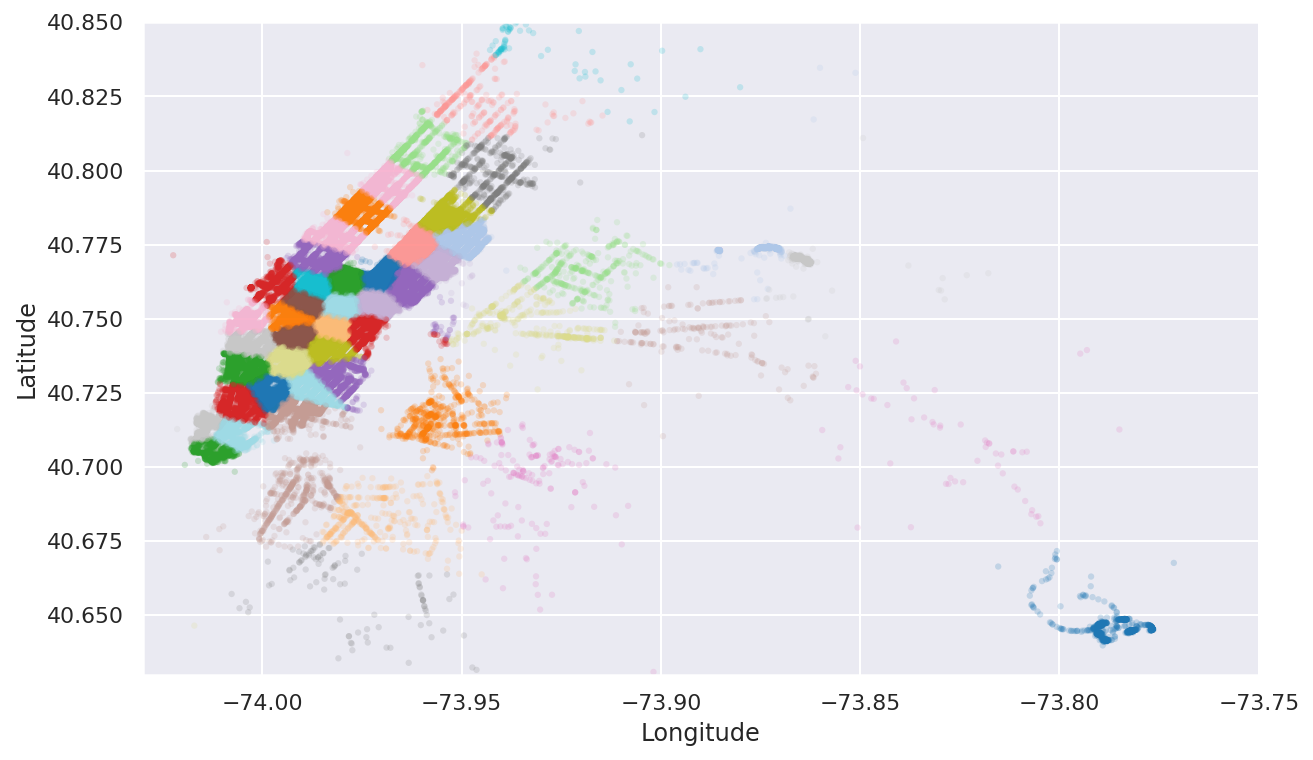

In [121]:
plot_clusters(data_2015_jan_with_durations)

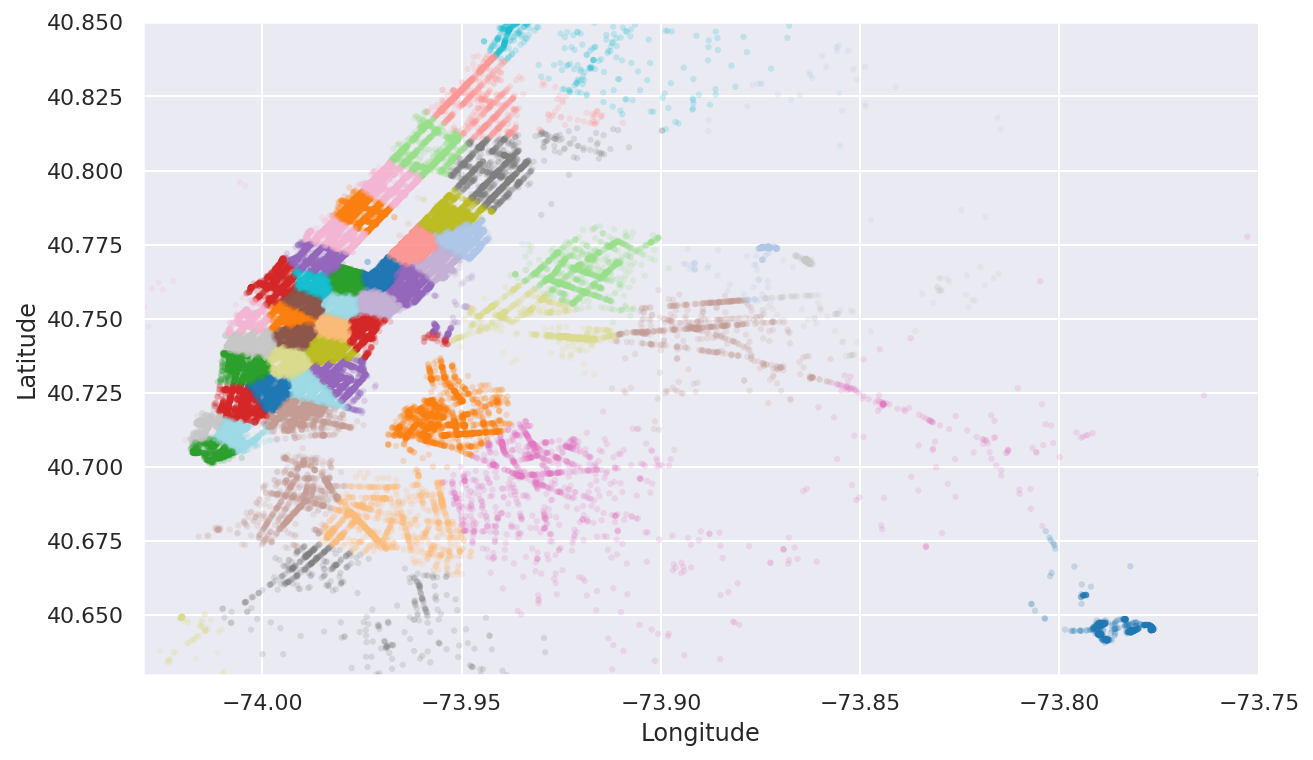

In [122]:
plot_clusters(data_2016_jan_with_durations)

## Time binning the compete dataset

In [126]:
def get_time_bin(unixtime, year, timezone='IST', binwidth=10):
    """
    Convert the unix timestamp into the right for the year
    given by `year`. Only 2015, 2016, 2017 is possible. It
    also handles the timezone and it split the data into
    `binwidth` size bins.
    
    :param unixtime: <int> Given unix time
    :param year: <int> Given year
    :param timezone: <str> Timezone
    :param binwidth: <int> Binwidth of time binning
    
    >> get_time_bin(1420133700, 2015, timezone='GMT')
    [out]: 105
    >> get_time_bin(1420133700, 2015, timezone='IST')
    [out]: 138
    """
    initial_time = [1388534400, 1420070400, 1451606400]
    first_jan_time = initial_time[year - 2014]
    factor = 60 * binwidth
    if unixtime < first_jan_time:
        raise ValueError('Unixtime {} is before the year {}'.format(unixtime, year))
    if timezone == 'IST':
        return (unixtime - first_jan_time) // factor + 33
    elif timezone == 'UTC' or timezone == 'GMT':
        return (unixtime - first_jan_time) // factor
    else:
        raise NotImplementedError('Other timezomes are not implemented yet')

In [127]:
data_2014_jan_with_durations['time_bins'] = data_2014_jan_with_durations.pickup_times.apply(
    get_time_bin, args=(2014,))

data_2015_jan_with_durations['time_bins'] = data_2015_jan_with_durations.pickup_times.apply(
    get_time_bin, args=(2015,))

data_2016_jan_with_durations['time_bins'] = data_2016_jan_with_durations.pickup_times.apply(
    get_time_bin, args=(2016,))

In [128]:
data_2014_jan_with_durations.time_bins.unique().shape

(4464,)

In [129]:
data_2015_jan_with_durations.time_bins.unique().shape

(4464,)

In [130]:
data_2016_jan_with_durations.time_bins.unique().shape

(4454,)

In [131]:
data_2014_jan_with_durations['time_bins'] = data_2014_jan_with_durations.time_bins.astype(int)
data_2015_jan_with_durations['time_bins'] = data_2015_jan_with_durations.time_bins.astype(int)
data_2016_jan_with_durations['time_bins'] = data_2016_jan_with_durations.time_bins.astype(int)

In [132]:
jan_2014_df = data_2014_jan_with_durations[['region', 'time_bins', 'trip_distance']].groupby(
    ['region', 'time_bins']).count()
jan_2015_df = data_2015_jan_with_durations[['region', 'time_bins', 'trip_distance']].groupby(
    ['region', 'time_bins']).count()
jan_2016_df = data_2016_jan_with_durations[['region', 'time_bins', 'trip_distance']].groupby(
    ['region', 'time_bins']).count()

In [133]:
jan_2014_df.head()

trip_distance
region time_bins               
0      33                   112
       34                   151
       35                   146
       36                   112
       37                   115

In [134]:
jan_2015_df.head()

trip_distance
region time_bins               
0      33                    78
       34                   132
       35                   142
       36                    88
       37                    94

In [135]:
jan_2016_df.head()

trip_distance
region time_bins               
0      33                    85
       34                   118
       35                   134
       36                   128
       37                   103

In [136]:
jan_2014_df.reset_index(inplace=True)
jan_2015_df.reset_index(inplace=True)
jan_2016_df.reset_index(inplace=True)

## Checkpoint 1

In [137]:
jan_2014_df.to_csv('./dataset/2014/jan_2014_df.csv', index=False)
jan_2015_df.to_csv('./dataset/2015/jan_2015_df.csv', index=False)
jan_2016_df.to_csv('./dataset/2016/jan_2016_df.csv', index=False)